# Sturdy Statistics Quickstart

In [1]:
# pip install sturdy-stats-sdk pandas plotly seaborn

In [2]:
from sturdystats import Index, Job

API_KEY = None

# 1. Load Data

Your first step is to find some data to work with.
At a minimum, each record should contain a key named `doc` with the content you want to analyze.
You may also include any other metadata that&rsquo;s available.

In this example, we&rsquo;ll look at a collection of abstracts for computer science papers about machine learning.
The `doc` field stores the (plain text) content of the abstract, and we also have metadata for the author, title, publication data, and *arxiv id*, which is an identifier for each paper in a public preprint database.

In [3]:
import pandas as pd
df = pd.read_parquet('data/optimization_abstracts.parquet')
df.head()

,arxiv_id,author,doc,published,title
0,2311.10359,Wenqing Wu,Highly parallelized workloads like machine l...,2024-02-05,FIKIT: Priority-Based Real-time GPU Multi-task...
1,2410.01228,Yifan Qiao,Many applications are leveraging large langu...,2024-10-03,ConServe: Harvesting GPUs for Low-Latency and ...
2,2202.13481,Minsoo Rhu,In cloud machine learning (ML) inference sys...,2022-03-01,PARIS and ELSA: An Elastic Scheduling Algorith...
3,1510.06895,Canyi Lu,The nuclear norm is widely used as a convex ...,2016-01-20,Nonconvex Nonsmooth Low-Rank Minimization via ...
4,2202.07896,Jiamin Li,Companies build separate training and infere...,2022-02-17,Aryl: An Elastic Cluster Scheduler for Deep Le...


# 2. Create an Index

The basic unit for Sturdy Statistics workflows is the _index_.
An index stores your data, indexes it for search, and allows you to query your data using SQL.
An index also allows you to train our machine learning models for more sophisticated analysis.

Indexes are private to your API key, and each index associated with your API key has a unique _name_ and a unique identifier known as the _index_id_.
For this demo, we&rsquo;ll go ahead and make a new index with the name `quickstart_cs.LG_version1`:

In [4]:
index = Index(API_key=API_KEY, name='quickstart_cs.LG_version1')

Created new index with id="index_c596199dd411476fafe921f6fb460f76".


# 3. Upload data and Train the index

With the Sturdy Stats SDK, it&rsquo;s a simple matter to upload your data, and train the index on your data.

If your data is stored in a pandas DataFrame, `df.to_dict("records")` will produce the right format to upload.

And we&rsquo;ll train with the setting `K=96` in order to make the training go a little faster.
TODO: replace with a `fast=True` option to the train SDK

In [5]:
# upload
res = index.upload(df.to_dict("records"))

#train
job = index.train(params=dict(), fast=True, wait=False)

Uploading data to UNTRAINED index for training.
uploading data to index...


committing changes to index "index_c596199dd411476fafe921f6fb460f76"...


If you train with the option `wait=False`, it returns a `Job` object.
You can use this object to track your training progress:

In [6]:
job.get_status()

{'index_id': 'index_c596199dd411476fafe921f6fb460f76',
 'job_id': '96354e79-4b42-43fb-9686-b74bbf351d64',
 'job_name': 'trainIndexV2',
 'startedAt': '2024-11-19 00:25:47.026000+00:00',
 'status': 'RUNNING'}

# 4. Explore Results

The training should take about 10 minutes.
In the meantime, we can look at an index that we&rsquo;ve already trained for you.

Once your training has completed, you can replace the `id` with your own `index_id`.
Then you&rsquo;ll be able to see results derived from your own data!

In [27]:
index2 = Index(API_key=API_KEY, id="index_6009f7ff3ece41779dc4d9dda146498f")
index2.get_status()

Found an existing index with id="index_6009f7ff3ece41779dc4d9dda146498f".


{'index_id': 'index_6009f7ff3ece41779dc4d9dda146498f',
 'name': 'quickstart_cs.LG__v3',
 'state': 'ready'}

In this quickstart, we&rsquo;ll just look at the _topics_ learned by the model.
We can retrieve them from the index like so:

In [28]:
df_topic = pd.DataFrame.from_records(index2.topicSearch()['topics'])
df_topic.head()

,executive_paragraph_summary,one_sentence_summary,prevalence,short_title,topic_group_id,topic_group_short_title,topic_id
0,This theme delves into the intricacies of spar...,The theme explores various methods and algorit...,0.138537,Sparse Optimization Methods,1,Advanced Techniques,57
1,The theme centers around innovative approaches...,Recent advancements in neural network methodol...,0.072408,Neural Network Innovations,5,Machine Learning Solutions,8
2,The recurring theme in the provided documents ...,The theme focuses on effective strategies for ...,0.055453,Cloud Resource Management,6,Network Optimization,26
3,The exploration of Mixed Integer Programming (...,Recent advancements in Mixed Integer Programmi...,0.053129,Mixed Integer Programming Innovations,0,Optimization Techniques,1
4,This theme emphasizes the critical need for dy...,The theme revolves around dynamic resource all...,0.051621,Dynamic Resource Allocation,5,Machine Learning Solutions,24


You can see that topics are grouped.
Plotly has a perfect visual for seeing how topics relate to one another:

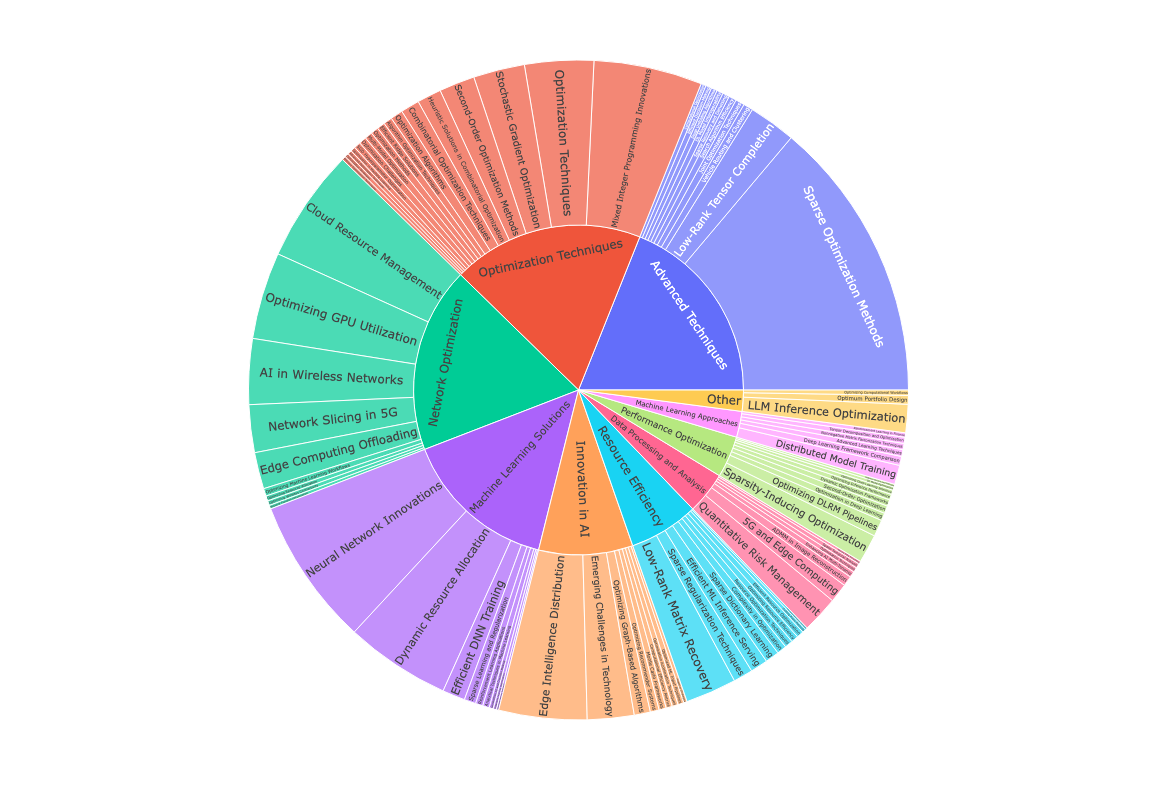

In [29]:
import plotly.express as px
from plotly.offline import iplot

fig = px.sunburst(df_topic, 
                  path=["topic_group_short_title", "short_title"], 
                  values="prevalence", 
                  hover_data=["topic_id"])

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

fig.show()

Note that you can click on groups in the inner ring to expand them.
And you can find the `topic_id` for any topic by hovering over it in the plot.

Maybe I&rsquo;m interested in the topic *Second-Order Optimization Methods*, with `topic_id=56`

In [30]:
topic_id = 71
df_topic.loc[topic_id == df_topic['topic_id']]

,executive_paragraph_summary,one_sentence_summary,prevalence,short_title,topic_group_id,topic_group_short_title,topic_id
16,The theme revolves around second-order optimiz...,Second-order optimization methods leverage Hes...,0.01748,Second-Order Optimization Methods,0,Optimization Techniques,71


You can see the index has a summary of the topic:

In [31]:
import textwrap
summ = df_topic.loc[topic_id == df_topic['topic_id'], 'executive_paragraph_summary'].values[0]
summ_wrap = "\n".join(textwrap.wrap(summ, 80)) # wrap text for easier reading
print(summ_wrap)

The theme revolves around second-order optimization methods that utilize
curvature information, specifically the Hessian or its approximations, to
enhance the efficiency and convergence rates in optimizing complex models such
as deep neural networks. Various techniques are discussed, including Natural
Gradient Descent, Information-Theoretic Trust Region Optimization, and diagonal
approximations of the Hessian, which aim to mitigate the computational
challenges associated with direct Hessian computation. Methods like Tensor
Normal Training and Shampoo highlight innovative approaches to maintain
performance while minimizing memory and computational costs. Research further
explores the integration of these second-order strategies with stochastic
gradient methods and their applications in convex and non-convex problems,
demonstrating practical effectiveness in real-world scenarios.


We can easily pull up all the abstracts that mention this topic

In [46]:
docs = pd.DataFrame(index2.query(topic_id=topic_id)["docs"])
for doc in docs.iloc[:3].to_dict("records"):
    print(doc["metadata"]["title"])
    print("\n".join(textwrap.wrap(doc["text"], 80)))
    print("\n")

New insights and perspectives on the natural gradient method
  Natural gradient descent is an optimization method traditionally motivated
from the perspective of information geometry, and works well for many
applications as an alternative to stochastic gradient descent. In this paper we
critically analyze this method and its properties, and show how it can be viewed
as a type of 2nd-order optimization method, with the Fisher information matrix
acting as a substitute for the Hessian. In many important cases, the Fisher
information matrix is shown to be equivalent to the Generalized Gauss-Newton
matrix, which both approximates the Hessian, but also has certain properties
that favor its use over the Hessian. This perspective turns out to have
significant implications for the design of a practical and robust natural
gradient optimizer, as it motivates the use of techniques like trust regions and
Tikhonov regularization. Additionally, we make a series of contributions to the
understanding o

And with a SQL query we can see how popular this topic has been over time:

In [47]:
df_timeseries = index2.queryMeta(
    query=f"""
SELECT published, sparse_list_extract({topic_id+1}, sum_topic_counts_inds, sum_topic_counts_vals) AS occurrences
FROM doc_meta
LIMIT 1000
"""
)

df_timeseries = pd.DataFrame.from_records(df_timeseries)

# group reviews by quarter.  seaborn requires TimeStamp objects, so we do 
#   TimeStamp -> Period('Q') -> TimeStamp
df_timeseries['published'] = df_timeseries['published'].apply(pd.Timestamp)
df_timeseries['year'] = df_timeseries['published'].dt.to_period('Y').dt.to_timestamp()

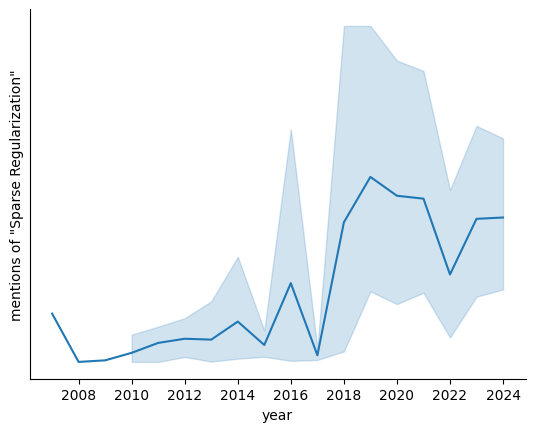

In [48]:
import seaborn as sns
ax = sns.lineplot(df_timeseries, x='year', y='occurrences')
ax.set_yticks([]); ax.set_ylabel('''mentions of "Sparse Regularization"''')
sns.despine(ax=ax)